# Tokenization

In [7]:
import re
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch



def tokenization(inputpath):

    df = pd.read_csv(inputpath)

    df['sentence'] = df['sentence'].astype(str)

    tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
    model = AutoModel.from_pretrained("yiyanghkust/finbert-tone")

    tokens = tokenizer(df['sentence'].tolist(), padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        embeddings = model(**tokens).last_hidden_state.mean(dim=1) 

    labels = torch.tensor(df['Label'])

    return embeddings, labels




/Users/alex/VSCodeProjects/financenews/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Splitting Data

In [8]:
import re
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

def prepare_data(inputpath, batch_size=32):
    embeddings, labels = tokenization(inputpath)
    X = embeddings.numpy()
    y = labels.numpy()

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
    test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = prepare_data('../cleaning/concatenated.csv', batch_size=32)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Model

In [9]:
import torch
class ANNs(torch.nn.Module):
    def __init__(self):
        super(ANNs,self).__init__()
        self.fc2 = torch.nn.Linear(768, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 2)

    def forward(self, x):
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    

In [10]:
ANN = ANNs()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ANN.parameters(), lr=0.001, weight_decay=0.0001)
best_val_loss = float('inf')
early_stopping_counter = 0

def trainclassifier(classifier, train_loader, val_loader, epochs=100):
    global best_val_loss
    global early_stopping_counter

    classifier.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.float()
            labels = labels.long()

            optimizer.zero_grad()

            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print('Epoch {}, Loss {}'.format(epoch, epoch_loss))

        classifier.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float()
                labels = labels.long()

                outputs = classifier(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        print('Validation Loss: {}'.format(val_loss))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(classifier.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= 10:
                print("Early stopping")
                break

trainclassifier(ANN, train_loader, val_loader)


Epoch 0, Loss 0.09012452937803767
Validation Loss: 0.08211206459591902
Epoch 1, Loss 0.04542673005232969
Validation Loss: 0.059064797661808686
Epoch 2, Loss 0.03267662562901983
Validation Loss: 0.0714992263752339
Epoch 3, Loss 0.026618885079638915
Validation Loss: 0.05757966011269884
Epoch 4, Loss 0.018894685912153892
Validation Loss: 0.07063217638845577
Epoch 5, Loss 0.018223535225671206
Validation Loss: 0.07717579339027167
Epoch 6, Loss 0.011876637122691673
Validation Loss: 0.07152804315088826
Epoch 7, Loss 0.004092796227789086
Validation Loss: 0.11451662822523123
Epoch 8, Loss 0.007036541269592022
Validation Loss: 0.0737126810881184
Epoch 9, Loss 0.018108211217713208
Validation Loss: 0.10129724857495942
Epoch 10, Loss 0.011995023166898
Validation Loss: 0.0906099046782359
Epoch 11, Loss 0.001005739915363958
Validation Loss: 0.10925267401370452
Epoch 12, Loss 7.195826183117368e-05
Validation Loss: 0.11421981607221107
Epoch 13, Loss 5.3422180846071094e-05
Validation Loss: 0.11466434938

Accuracy: 0.9844213649851632


/var/folders/34/4m3rx1zd32dgvl3g8t313g900000gn/T/ipykernel_11565/2900073222.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load('best_mode

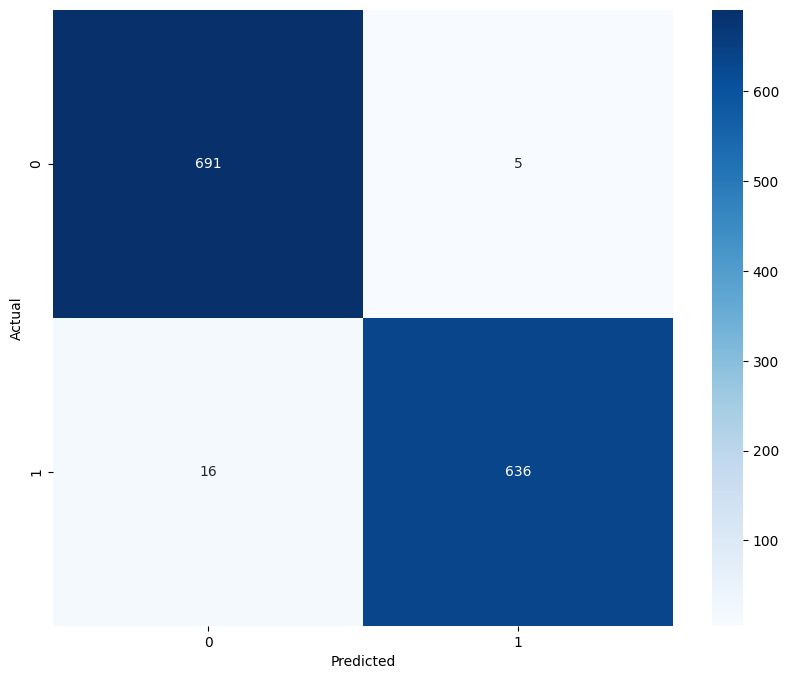

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

network = ANNs()

network.load_state_dict(torch.load('best_model.pth'))

network.eval()


def evaluate(classifier, test_loader):
    classifier.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs , labels in test_loader:
            inputs = inputs.float()
            labels = labels.long()

            outputs = classifier(inputs)
            _, predicted = torch.max(outputs, 1)


            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print('Accuracy: {}'.format(accuracy))
    confusion = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate(network, test_loader)
